# S&P500 Forecasting

- **Autores:** Guilherme Magalhães, João Baptista, Francisco Martins, Nuno Moreira
- **Universidade:** Faculdade de Ciências da Universidade do Porto
- **Cadeira:** Laboratório de Inteligência Artificial e Ciência de Dados (CC3044)

## Problema

No contexto da cadeira de LABIACD (CC3044), foi-nos pedido para desenvolver um modelo de aprendizagem computacional, capaz de prever os preços futuros das ações (stocks) do índice S&P500, e aplicar métodos de otimização para selecionar o melhor conjunto de stocks para investimento diário.

## Contexto Cronológico

No decorrer deste projeto, simulamos um contexto de trabalho em que, no final de dezembro de 2023, um investidor nos pediu um programa capaz de prever os preços das ações do índice S&P500, para todos os dias de janeiro de 2024. Assim, elaboramos um modelo que combina previsões baseadas em dados históricos (desde janeiro de 2013 até dezembro de 2023) com técnicas de otimização, para maximizar o retorno, criando uma solução para os desafios financeiros do mundo real.

## Introdução
Neste notebook, iremos realizar a extração e o pré-processamento dos dados históricos do índice S&P500. Em seguida, iremos utilizar os dados processados para realizar o feature engineering e o treino do modelo, no notebook *model.ipynb*.

### Imports Necessários

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yahoo_fin.stock_info as si
import os

### Extração dos Dados
Em primeiro lugar, vamos extrair e analisar informações do S&P500, através da Wikipedia.

In [8]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
SP500_company_data = pd.read_html(url)[0]
SP500_company_data.to_csv("companies_data.csv")

In [4]:
SP500_company_data.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


Como podemos observar, cada linha corresponde a um stock diferente.

In [7]:
uniqueStocks = np.unique(SP500_company_data.Symbol.to_numpy())
print(f"Existem {uniqueStocks.size} stocks diferentes de {SP500_company_data.shape[0]} disponíveis no índice S&P500.")

Existem 503 stocks diferentes de 503 disponíveis no índice S&P500.


De seguida, analisamos a distribuição de empresas por setor.

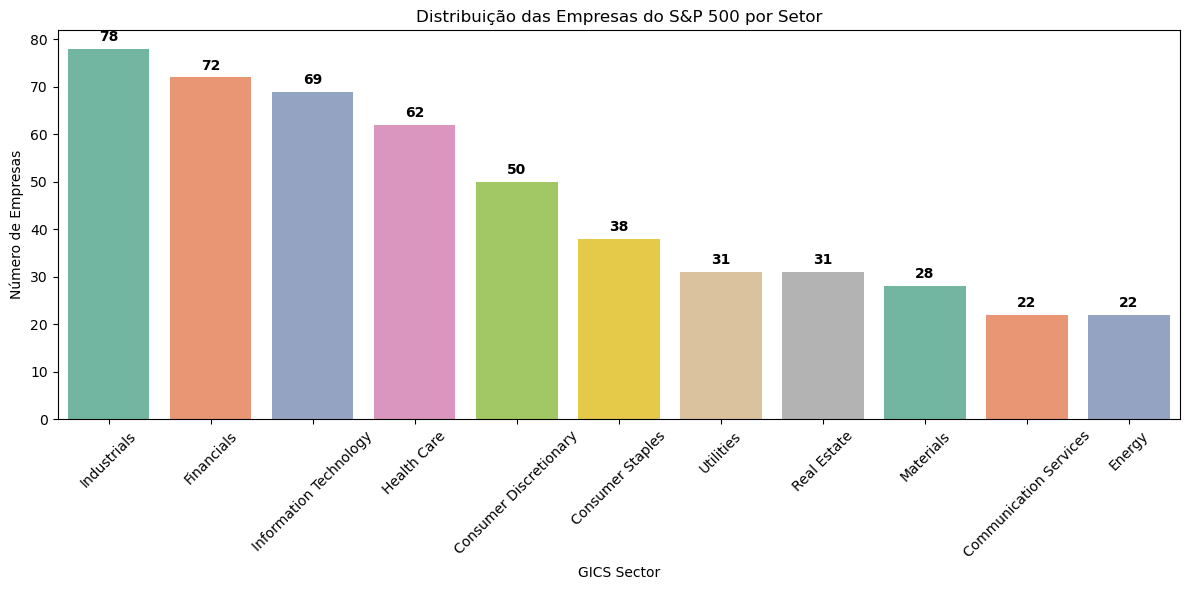

In [14]:
sector_counts = SP500_company_data['GICS Sector'].value_counts()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=sector_counts.index, y=sector_counts.values, palette='Set2')

for i, count in enumerate(sector_counts.values):
    ax.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Distribuição das Empresas do S&P 500 por Setor')
plt.xlabel('GICS Sector')
plt.ylabel('Número de Empresas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Como podemos observar, a maioria dos stocks situam-se nos setores *Industrials*, *Financials* e *Information Technology*, sendo que a minoria está presente nos setores *Comunication Services* e *Energy*.

### Dados Históricos

De forma a analisar a performance do fundo S&P500, extraímos os dados históricos do mesmo, desde 1 de janeiro de 2013 até 31 de dezembro de 2023 e guardamos num DataFrame (df). De seguida, utilizamos esse df para analisar o conjunto de dados e visualizar a evolução do S&P500 no que toca ao preço médio de fecho dos stocks. 

In [15]:
SP500_historical_data = pd.DataFrame()

for company in SP500_company_data['Symbol']:
    try:
        company_data = si.get_data(company, start_date="01/01/2013", end_date="12/31/2023", index_as_date = True, interval="1d")
        SP500_historical_data = pd.concat([SP500_historical_data, company_data])
    except:
        ...

SP500_historical_data.to_csv("stocks_historical_data.csv")

In [36]:
# Inspecionar o DataFrame
SP500_historical_data.head()

,open,high,low,close,adjclose,volume,ticker,date
2013-01-02,78.754181,79.255852,78.561874,79.247490,54.016640,3835213,MMM,2013-01-02
2013-01-03,78.879601,79.372910,78.704010,79.155518,53.953953,3234702,MMM,2013-01-03
2013-01-04,79.255852,79.832779,79.046822,79.740807,54.352924,3235060,MMM,2013-01-04
2013-01-07,79.448158,80.041809,79.230766,79.841141,54.421288,3283977,MMM,2013-01-07
2013-01-08,79.573578,80.058525,79.515053,79.849495,54.426994,3175978,MMM,2013-01-08


Para visualizar a sua evolução, agrupamos os dados por dia e calculamos a média dos preços da coluna 'close' para cada um deles. Em seguida, demos plot desses mesmos dados ao longo dos últimos 10 anos.

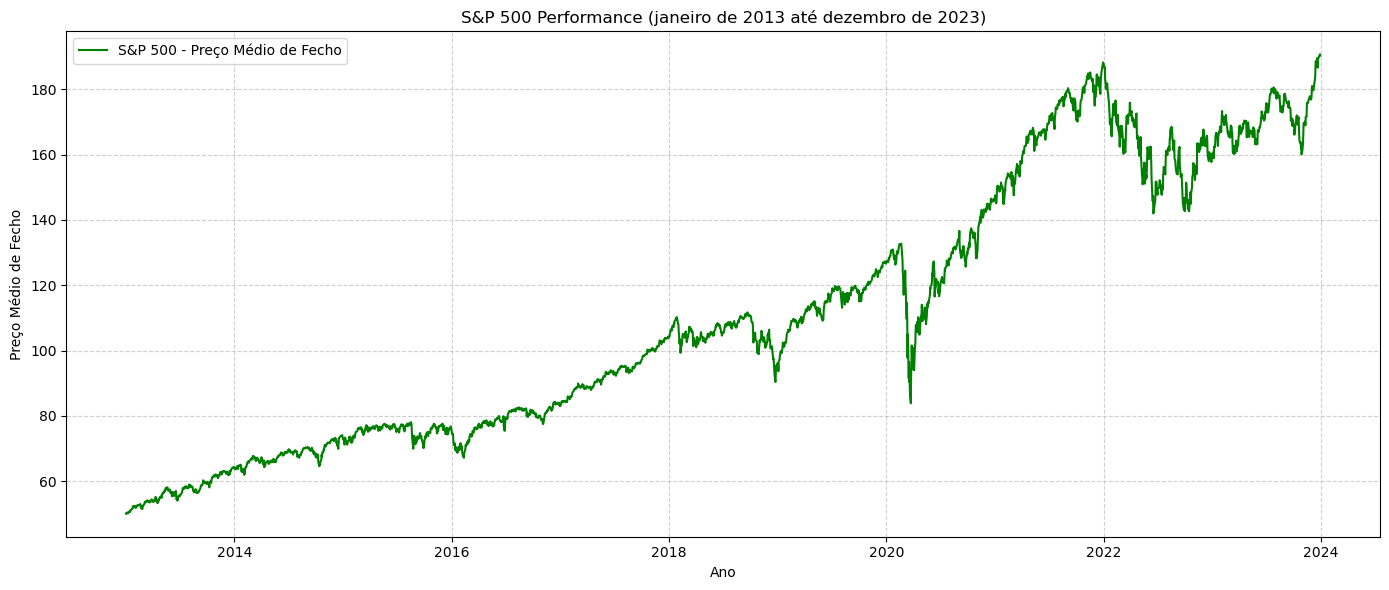

In [24]:
SP500_historical_data['date'] = pd.to_datetime(SP500_historical_data.index)
sp500_daily_performance = SP500_historical_data.groupby('date')['close'].mean()

plt.figure(figsize=(14, 6))
plt.plot(sp500_daily_performance, label='S&P 500 - Preço Médio de Fecho', color='green')
plt.title('S&P 500 Performance (janeiro de 2013 até dezembro de 2023)')
plt.xlabel('Ano')
plt.ylabel('Preço Médio de Fecho')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Na última decada, o índice do mercado S&P500 demonstrou um **crescimento significativo** no que toca à média do preço de fecho, por dia. Este crescimento evidenciado traduz o seu potencial como um **investimento lucrativo** para qualquer investidor que o queira adicionar ao seu **portfolio**.

### Dados de Treino e Teste
Decidimos separar os dados históricos da seguinte forma:
- Treino: desde janeiro de 2013 até outubro de 2023
- Teste: desde novembro de 2023 até dezembro de 2023 

Desta forma, vamos utilizar os dados de treino para avaliar quais são os 5 setores com maior crescimento mensal e escolher as 30 melhores empresas de cada um. Depois disso, no notebook *model.ipynb*, realizamos *feature engineering* nos dois datasets. Nesse notebook, os dados de teste representam, para já, os dados futuros que estamos a tentar prever, de forma a avaliar a performance do modelo com dados que nunca viu (mas que temos acesso), evitando assim data leakage.

### Dados para Treino

In [34]:
SP500_train_data = pd.DataFrame()

for company in SP500_company_data['Symbol']:
    try:
        company_data = si.get_data(company, start_date="01/01/2013", end_date="11/01/2023", index_as_date = True, interval="1d")
        SP500_train_data = pd.concat([SP500_train_data, company_data])
    except:
        ...

SP500_train_data.to_csv("stocks_train_data.csv")

In [38]:
SP500_train_data.tail(20)

,open,high,low,close,adjclose,volume,ticker
2023-10-04,171.119995,171.539993,169.190002,170.990005,168.908691,1673400,ZTS
2023-10-05,171.190002,172.580002,170.009995,172.000000,169.906387,2083200,ZTS
2023-10-06,171.779999,175.929993,170.279999,175.580002,173.442825,1490600,ZTS
2023-10-09,173.610001,175.399994,172.250000,174.600006,172.474747,1215100,ZTS
2023-10-10,174.289993,176.789993,173.550003,175.630005,173.492218,1665300,ZTS
2023-10-11,176.660004,177.330002,175.020004,176.949997,174.796158,1053600,ZTS
2023-10-12,176.830002,177.550003,174.210007,174.309998,172.188278,1306300,ZTS
2023-10-13,173.419998,175.729996,173.000000,174.380005,172.257431,1287400,ZTS
2023-10-16,175.009995,176.539993,173.669998,175.179993,173.047684,1264400,ZTS
2023-10-17,172.869995,174.429993,171.380005,174.259995,172.138870,1716300,ZTS


### Dados para Teste
No *feature engineering* que realizamos, calculamos a *deviation* de cada dia, utilizando os valores dos 20 dias anteriores, assim, de forma a utilizar todos os dados de novembro (evitando valores NaN), o nosso dataset de treino começa no dia 4 de outubro. Como podemos ver pela célula acima, os últimos 20 dias de stock antes de novembro começam no dia 4 de outubro de 2023.

In [37]:
SP500_test_data = pd.DataFrame()

for company in SP500_company_data['Symbol']:
    try:
        company_data = si.get_data(company, start_date="10/04/2023", end_date="12/31/2023", index_as_date = True, interval="1d")
        SP500_test_data = pd.concat([SP500_test_data, company_data])
    except:
        ...

SP500_test_data.to_csv("stocks_test_data.csv")

In [39]:
SP500_test_data.tail(20)

,open,high,low,close,adjclose,volume,ticker
2023-12-01,176.250000,179.460007,175.979996,179.130005,177.373260,1367200,ZTS
2023-12-04,178.809998,182.660004,178.809998,182.119995,180.333939,1559500,ZTS
2023-12-05,181.289993,182.039993,178.860001,179.649994,177.888168,1425900,ZTS
2023-12-06,180.750000,183.179993,180.639999,182.000000,180.215118,1552900,ZTS
2023-12-07,182.460007,182.600006,180.509995,181.830002,180.046799,1088600,ZTS
2023-12-08,182.080002,184.850006,181.470001,184.600006,182.789627,1474600,ZTS
2023-12-11,185.169998,190.149994,184.679993,189.460007,187.601974,3199200,ZTS
2023-12-12,190.080002,192.500000,188.919998,191.470001,189.592255,1899700,ZTS
2023-12-13,191.779999,197.669998,190.940002,197.410004,195.473999,2104700,ZTS
2023-12-14,198.000000,201.919998,198.000000,200.089996,198.127716,3044400,ZTS


### Dados para Simulação
Estes dados serão usados para simular e avaliar a performance da otimização do portfolio.
Pela mesma razão descrita acima, a *start_date* dos dados de janeiro de 2024 é o dia 1 de dezembro de 2023.

In [40]:
SP500_simulate_data = pd.DataFrame()

for company in SP500_company_data['Symbol']:
    try:
        company_data = si.get_data(company, start_date="12/1/2023", end_date="01/31/2024", index_as_date = True, interval="1d")
        SP500_simulate_data = pd.concat([SP500_simulate_data, company_data])
    except:
        ...

SP500_simulate_data.to_csv("stocks_simulate_data.csv")

### Identificar os Melhores Setores e Respetivas Empresas

Identificamos quais são os 5 setores com maior crescimento mensal e escolhemos as 30 melhores empresas de cada um deles.

##### Função de Crescimento Mensal por Empresa

In [29]:
def get_growth(df):
    # retorna o crescimento mensal da empresa 
    monthly_growth = 0
    monthly = df['close'].resample('ME').agg(['first', 'last'])
    
    for _, row in monthly.iterrows():
        monthly_growth += ((row['last'] - row['first']) / row['first']) * 100
        
    return monthly_growth/len(monthly)

##### Cálculo dos Setores e Respetivas Empresas

In [43]:
growth = {}
sectors_growth = {}
for sector in SP500_company_data["GICS Sector"].unique():
    mean_growth_sector = 0
    sector_data = SP500_company_data[SP500_company_data["GICS Sector"] == sector]
    data = {}
    
    for company in sector_data["Symbol"]: 
        try:
            stock_growth = get_growth(SP500_train_data[SP500_train_data["ticker"]==company])
            mean_growth_sector += stock_growth
            data[company] = stock_growth
        except:
            ...
    growth[sector] = dict(sorted(data.items(), key=lambda item: item[1], reverse=True)) 
    sectors_growth[sector] = mean_growth_sector/len(data)
# ordenar em forma decrescente
sectors_growth = dict(sorted(sectors_growth.items(), key=lambda item: item[1], reverse=True))

if not os.path.exists("dataset_by_sector/"):
    os.mkdir("dataset_by_sector/")
j = 1
for sector,m_growth in sectors_growth.items():
    if j > 5: break
    i = 1
    print(f"{j}) Setor: {sector} (avg monthly growth: {m_growth:.4f}%) - all companies in sector")
    if len(growth[sector]) < 30:    
        print(f"    < {len(growth[sector])} best companies >")
    else: 
        print("    < 30 best companies >")
    for company,data in growth[sector].items():
        if i > 30: break
        print(f"    {company} - avg monthly growth: {data:.4f}%")
        i += 1

    j += 1

1) Setor: Information Technology (avg monthly growth: 1.6906%) - all companies in sector
    < 30 best companies >
    PLTR - avg monthly growth: 4.8093%
    ENPH - avg monthly growth: 4.5056%
    NVDA - avg monthly growth: 4.3222%
    AMD - avg monthly growth: 3.2526%
    CRWD - avg monthly growth: 3.1527%
    ANET - avg monthly growth: 2.9773%
    AVGO - avg monthly growth: 2.8534%
    NOW - avg monthly growth: 2.7821%
    MPWR - avg monthly growth: 2.6723%
    PANW - avg monthly growth: 2.6632%
    SMCI - avg monthly growth: 2.6045%
    EPAM - avg monthly growth: 2.5880%
    FTNT - avg monthly growth: 2.4486%
    CDNS - avg monthly growth: 2.4176%
    LRCX - avg monthly growth: 2.3566%
    FICO - avg monthly growth: 2.3395%
    SNPS - avg monthly growth: 2.2480%
    ADBE - avg monthly growth: 2.1802%
    MU - avg monthly growth: 2.1777%
    AMAT - avg monthly growth: 2.0917%
    ZBRA - avg monthly growth: 2.0421%
    MSFT - avg monthly growth: 2.0040%
    KLAC - avg monthly growth: 

**Nota**: Como o setor *Energy* só contém 22 empresas, todas elas são escolhidas.

### Guardar os dados

Vamos agora guardar os dados das melhores empresas por setor.

In [17]:
if not os.path.exists("dataset_by_sector/train/"):
    os.mkdir("dataset_by_sector/train/")
    
if not os.path.exists("dataset_by_sector/test/"):
    os.mkdir("dataset_by_sector/test/")    

if not os.path.exists("dataset_by_sector/simulate/"):
    os.mkdir("dataset_by_sector/simulate/")    
    
limit_sector = 1

for sector,m_growth in sectors_growth.items():
    if limit_sector > 5: break
    limit_companies = 1
    
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    df_simulate = pd.DataFrame()
    
    for company,data in growth[sector].items():
        if limit_companies > 30: break

        df_train = pd.concat([df_train,SP500_train_data[SP500_train_data["ticker"]==company]])
        df_test = pd.concat([df_test,SP500_test_data[SP500_test_data["ticker"]==company]])
        df_simulate = pd.concat([df_test,SP500_simulate_data[SP500_simulate_data["ticker"]==company]])
        limit_companies += 1

    df_train.to_csv(f"dataset_by_sector/train/{sector.replace(' ','_')}.csv")
    df_test.to_csv(f"dataset_by_sector/test/{sector.replace(' ','_')}.csv")
    df_simulate.to_csv(f"dataset_by_sector/simulate/{sector.replace(' ','_')}.csv")
    limit_sector += 1


### Remover os datasets iniciais 

Remover os datasets que já não são necessários

In [18]:
del_files = ["companies_data.csv","stocks_train_data.csv","stocks_test_data.csv","stocks_simulate_data.csv"]

for csv_file in del_files:
    if os.path.exists(csv_file):
        os.remove(csv_file)
        print(f"Ficheiro '{csv_file}' removido com sucesso.")
    else:
        print(f"Ficheiro '{csv_file}' não encontrado.")

Ficheiro 'companies_data.csv' removido com sucesso.
Ficheiro 'stocks_train_data.csv' removido com sucesso.
Ficheiro 'stocks_test_data.csv' removido com sucesso.
